In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g29afe694f1+a272651890 	current w_2023_40 setup
alert_packet          g6041bd2d66 	current w_2023_40 setup
analysis_drp          g8a53795882+0c0064919b 	current w_2023_40 setup
analysis_tools        g01ff57b274+b4ae54b57f 	current w_2023_40 setup
ap_association        g9b2d7c2ad1+0898bae26d 	current w_2023_40 setup
ap_pipe               g9f065385ad+72c0e07383 	current w_2023_40 setup
ap_verify             g60239a501b+d279a3926c 	current w_2023_40 setup
astro_metadata_translator g0978aabd1f+0ffa813159 	current w_2023_40 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_40 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_40 setup
cbp                   ga32fcf49c8+650be1a39c 	current w_2023_40 setup
cell_coadds           g9faf7ed3f3+0c0064919b 	current w_2023_40 setup
coadd_utils           g337abbeb29+650be1a39c 	current w_2023_40 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

We check the different dimension records existing for *physical_filter*: 

In [10]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [11]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [12]:
obs_type = 'science'
obs_day = 20230926
physical_filter = 'empty~holo4_003' 
science_program = 'BLOCK-102'

In [13]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [14]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}' AND exposure.science_program='{3}'".format(obs_type,obs_day,physical_filter,science_program)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023092600446
  physical_filter: 'empty~holo4_003'
  obs_id: 'AT_O_20230926_000446'
  exposure_time: 30.0
  dark_time: 30.2346
  observation_type: 'science'
  observation_reason: 'sitcom-1043'
  day_obs: 20230926
  seq_num: 446
  seq_start: 446
  seq_end: 446
  group_name: '2023-09-27T02:51:35.414'
  group_id: 2757126954140000
  target_name: 'HD2811'
  science_program: 'BLOCK-102'
  tracking_ra: 7.827800206545046
  tracking_dec: -43.60460268648411
  sky_angle: 19.097270869928906
  azimuth: 127.53812441035177
  zenith_angle: 27.05391872351369
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-27 02:54:18.911003', scale='tai', format='iso'), end=astropy.time.Time('2023-09-27 02:54:49.146000', scale='tai', format='iso'))
	 timespan:             [2023-09-27T02:54:18.911003, 2023-09-27T02:54:49.146000)
	 timespan.begin:       2023-09-27 02:54:18.911003
	 id:                   2023092600446
	 day_obs:              20230926
	 

In [15]:
print('Number of entries = ',len(df_science))

Number of entries =  68


In [16]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,exp_time,ra,dec,skyangle,science_program
63,2023092600512,AT_O_20230926_000512,20230926,512,2023-09-27 03:42:47.848997,2023-09-27 03:42:58.081,science,HD2811,empty~holo4_003,19.270444,10.0,7.829349,-43.603302,31.841295,BLOCK-102
64,2023092600513,AT_O_20230926_000513,20230926,513,2023-09-27 03:43:21.583998,2023-09-27 03:43:31.825,science,HD2811,empty~holo4_003,19.188712,10.0,7.830427,-43.602159,31.841293,BLOCK-102
65,2023092600514,AT_O_20230926_000514,20230926,514,2023-09-27 03:43:44.508999,2023-09-27 03:43:54.753,science,HD2811,empty~holo4_003,19.133679,10.0,7.830462,-43.602179,31.841334,BLOCK-102
66,2023092600515,AT_O_20230926_000515,20230926,515,2023-09-27 03:44:18.201997,2023-09-27 03:44:28.438,science,HD2811,empty~holo4_003,19.054660,10.0,7.831341,-43.600949,31.841343,BLOCK-102
67,2023092600516,AT_O_20230926_000516,20230926,516,2023-09-27 03:44:41.214988,2023-09-27 03:44:51.445,science,HD2811,empty~holo4_003,18.999954,10.0,7.831390,-43.600935,31.841309,BLOCK-102


Select exposures: 

In [17]:
seq_nums = np.sort(np.array(df_science.seq_num))
print(seq_nums)

[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516]


In [18]:
ids = np.sort(np.array(df_science.id))
print(ids)

[2023092600446 2023092600447 2023092600448 2023092600449 2023092600450
 2023092600451 2023092600452 2023092600453 2023092600454 2023092600455
 2023092600456 2023092600457 2023092600458 2023092600459 2023092600460
 2023092600461 2023092600462 2023092600463 2023092600464 2023092600465
 2023092600466 2023092600467 2023092600468 2023092600469 2023092600470
 2023092600471 2023092600472 2023092600473 2023092600474 2023092600475
 2023092600476 2023092600477 2023092600478 2023092600479 2023092600480
 2023092600481 2023092600485 2023092600486 2023092600487 2023092600488
 2023092600489 2023092600490 2023092600491 2023092600492 2023092600493
 2023092600494 2023092600495 2023092600496 2023092600497 2023092600498
 2023092600499 2023092600500 2023092600501 2023092600502 2023092600503
 2023092600504 2023092600505 2023092600506 2023092600507 2023092600508
 2023092600509 2023092600510 2023092600511 2023092600512 2023092600513
 2023092600514 2023092600515 2023092600516]


In [19]:
seq_nums = np.sort(np.array(df_science.seq_num))
ids = np.sort(np.array(df_science.id))

In [20]:
print(len(seq_nums))

68


We select an exposure that we know it was taken at the nominal position 

In [38]:
nom_seq = 462
seq_num0 = seq_nums[seq_nums==nom_seq][0]
exp_id0 = ids[seq_nums==nom_seq][0]
print(exp_id0)

2023092600462


In [22]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

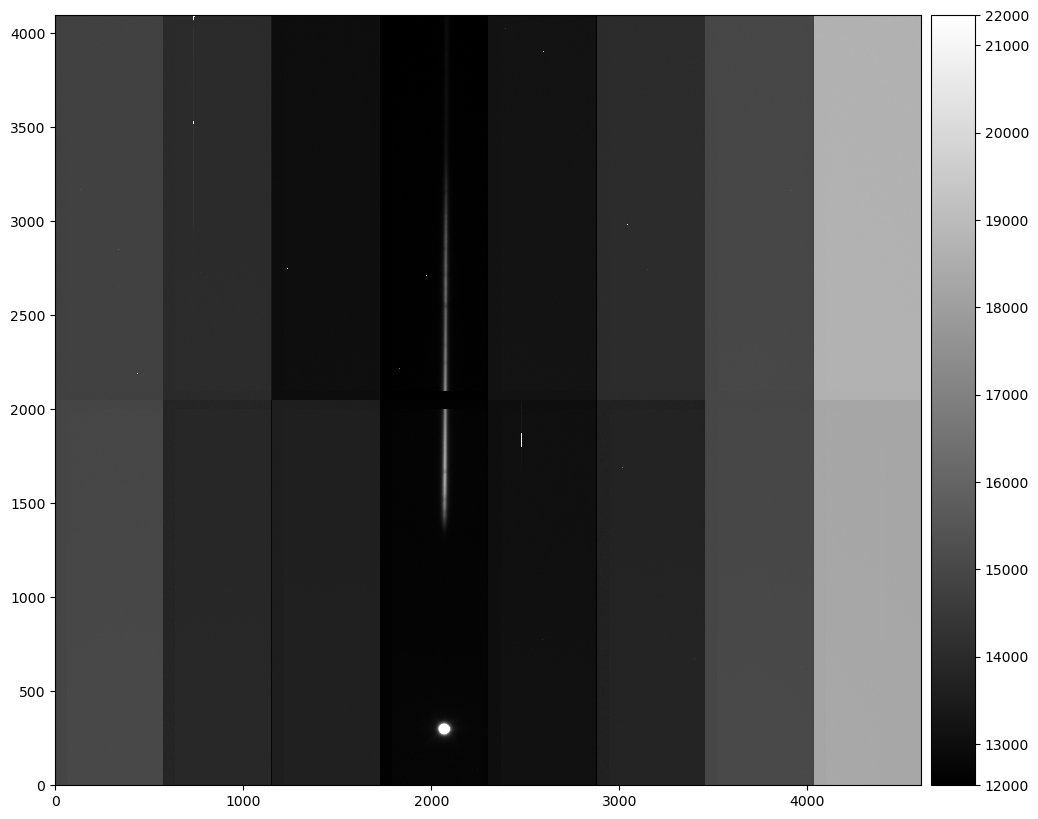

In [23]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

## Organize amplifiers 

In [24]:
ampli_boxes = {}
ampli_names = []
for ampIdx, amp in enumerate(test_img.getDetector()):
    ampli_name_ = amp.getName()
    ampli_names.append(ampli_name_)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)

In [25]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [26]:
# configuration
isr_config =  IsrTaskConfig()

In [27]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [28]:
isr_task = IsrTask(config=isr_config)

In [29]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [30]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [31]:
test_ = isr_test.exposure.image.array

Value range 

In [32]:
np.min(test_.flatten())

-64.65188

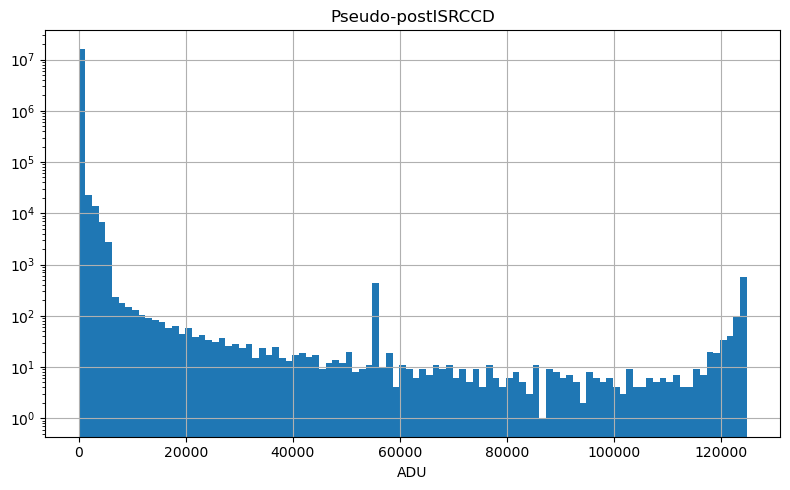

In [33]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Pseudo-postISRCCD')
plt.tight_layout()

In [34]:
nom_y = 290

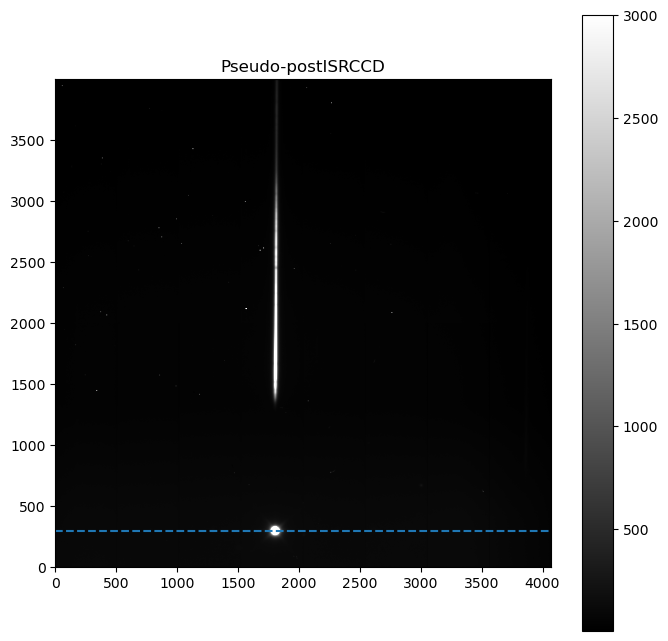

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=5,vmax=3000)
ax.axhline(y=nom_y,ls='--')
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [36]:

img_dict = {}
for i,id_ in enumerate(ids):
    print(id_)
    
    raw_ = butler.get('raw', dataId={'exposure': id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    bias_ = butler.get("bias",instrument=cameraName, exposure= id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    isr_ = isr_task.run(raw_,bias=bias_,defects=defects_)
    img_ = isr_.exposure.image.array
    
    img_dict[id_] = img_
    
    del(raw_)
    del(bias_)
    del(defects_)
    del(isr_)
    del(img_)
    

2023092600446


2023092600447


2023092600448


2023092600449


2023092600450


2023092600451


2023092600452


2023092600453


2023092600454


2023092600455


2023092600456


2023092600457


2023092600458


2023092600459


2023092600460


2023092600461


2023092600462


2023092600463


2023092600464


2023092600465


2023092600466


2023092600467


2023092600468


2023092600469


2023092600470


2023092600471


2023092600472


2023092600473


2023092600474


2023092600475


2023092600476


2023092600477


2023092600478


2023092600479


2023092600480


2023092600481


2023092600485


2023092600486


2023092600487


2023092600488


2023092600489


2023092600490


2023092600491


2023092600492


2023092600493


2023092600494


2023092600495


2023092600496


2023092600497


2023092600498


2023092600499


2023092600500


2023092600501


2023092600502


2023092600503


2023092600504


2023092600505


2023092600506


2023092600507


2023092600508


2023092600509


2023092600510


2023092600511


2023092600512


2023092600513


2023092600514


2023092600515


2023092600516


In [42]:
ampli0 = 'C03'
print(ampli_boxes[ampli0])
x0 = ampli_boxes[ampli0][0]
x1 = ampli_boxes[ampli0][1]
y0 = ampli_boxes[ampli0][2]
y1 = ampli_boxes[ampli0][3]

(1527, 2036, 0, 2000)


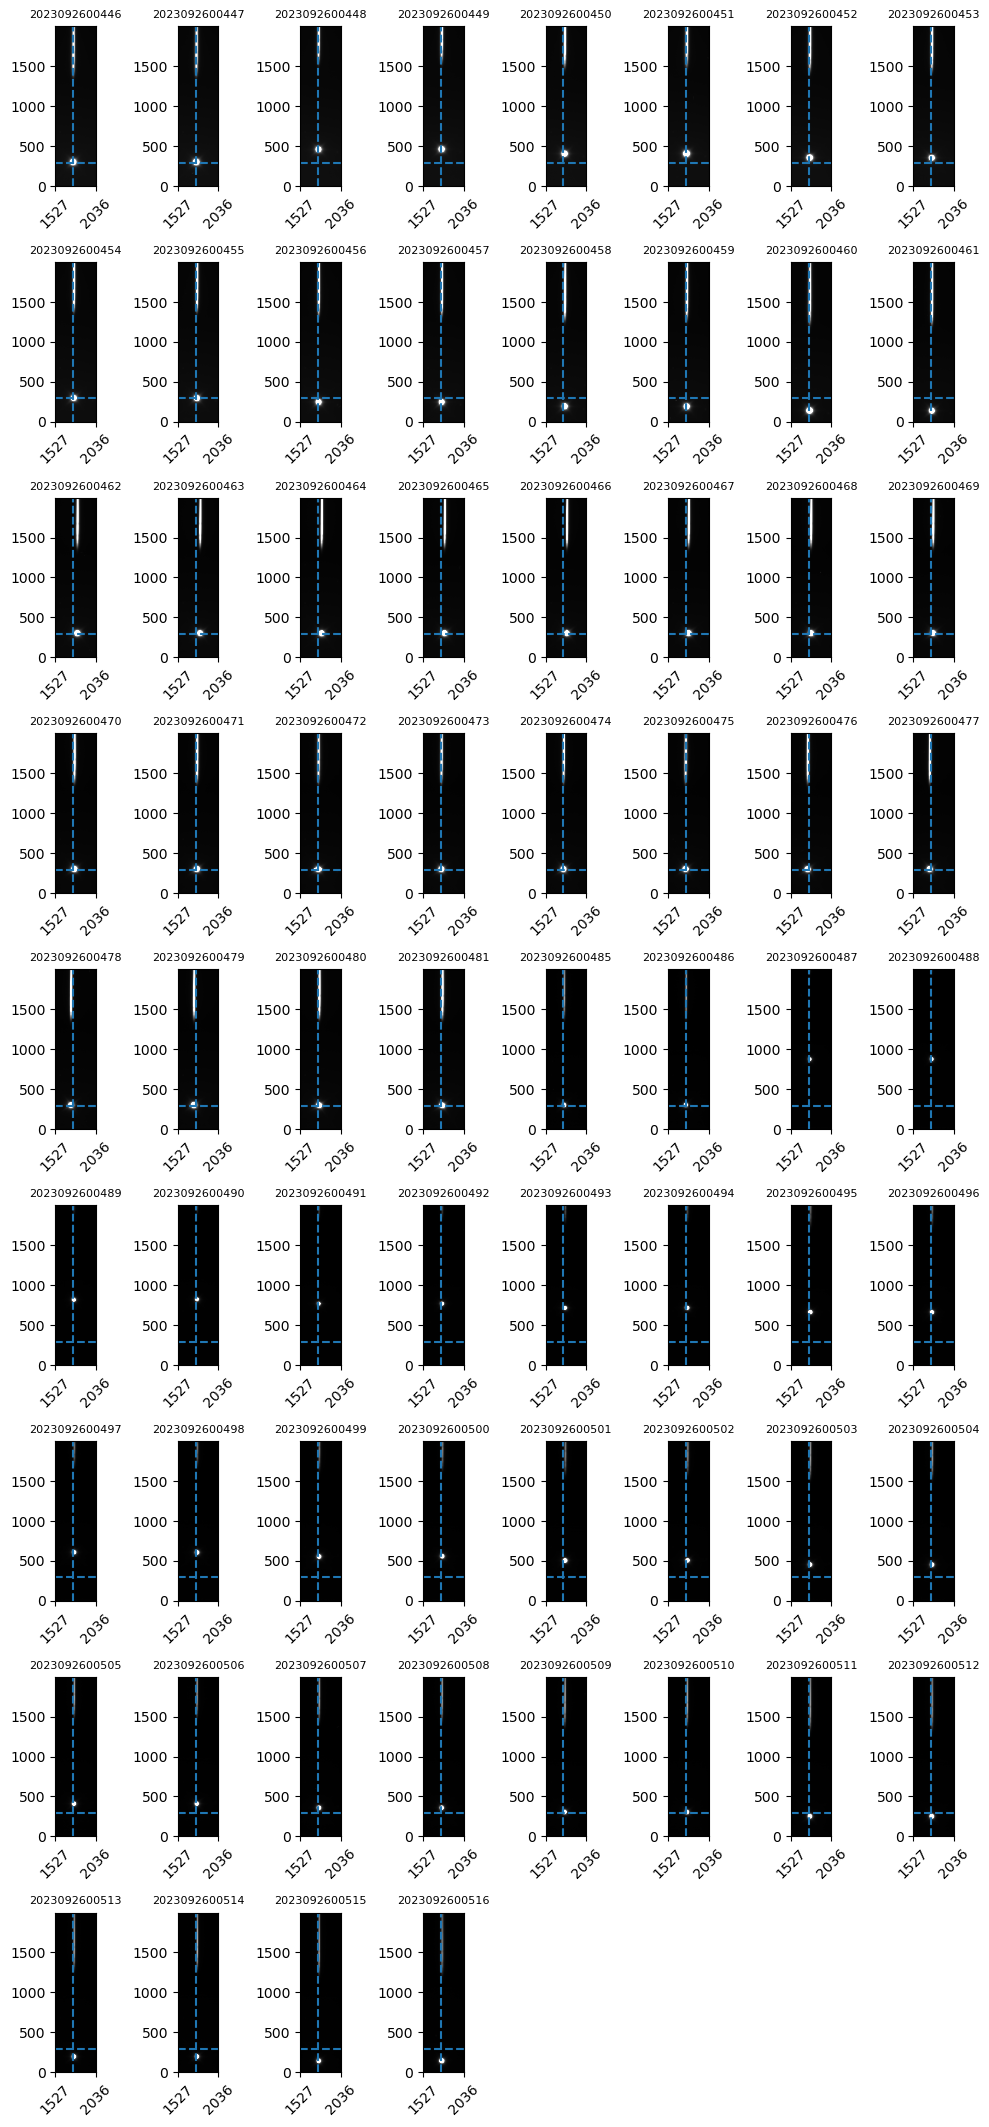

In [77]:
fig = plt.figure(figsize=(10,28))

num_cols = 8
num_rows = int(len(ids)/num_cols)+int(len(ids)%num_cols)

img_list = []
for i,id_ in enumerate(ids):
    img_ = img_dict[id_]
    
    ax = fig.add_subplot(num_rows,num_cols,i+1)
    #im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
    im = ax.imshow(img_[y0:y1,x0:x1],cmap="gray",origin='lower',vmin=5,vmax=3000)
    
    xticks = np.array([0,x1-x0])
    xticks_label = np.array([x0,x1])
    ax.set_xticks(xticks,labels=xticks_label,rotation=45)
    
    ax.axvline(x=1750-x0,ls='--')
    ax.axhline(y=nom_y,ls='--')
    
    ax.set_title(id_,fontsize=8)

plt.tight_layout()